This notebook performs decoding experiments that predict, on a moment by moment basis,
the lick direction of the animal, based on the neural activity. 

Key structs:
* `data_opts` - Set options about how the neural data and labeling data is structured. 

* `neuron_opts` - For a given classification run, defines which neurons are included. An experiment group is defined by a sequence of `neuron_opts` structs. 

* `train_opts` - Parameters of the training algorithm (i.e. neural net size etc.)

For plotting the outcomes of decoding experiments, see fig_classification_summary notebook.


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext line_profiler
# %pdb

import os
import sys
os.environ['MKL_THREADING_LAYER'] = 'GNU'

from matplotlib import pyplot as plt
import numpy as np
import scipy.stats

# from sklearn.utils.class_weight import compute_class_weight
# from sklearn.metrics import confusion_matrix

from sklearn.decomposition import PCA
import sklearn.feature_selection as feature_selection
from scipy.ndimage.filters import gaussian_filter1d

import pickle 
import keras
import time
import copy

from cosmos.traces.decoding_utils import *
from cosmos.traces.decoding.metrics import get_R2, get_rho
from cosmos.traces.decoding.decoders import DenseNNDecoder, LSTMDecoder
from cosmos.traces.decoding.decoders import GRUDecoder, SVRDecoder, XGBoostDecoder, SimpleRNNDecoder

import cosmos.traces.trace_analysis_utils as utils
from cosmos.behavior.bpod_dataset import BpodDataset
from cosmos.traces.cell_plotter import CellPlotter
from cosmos.traces.cosmos_traces import CosmosTraces
import cosmos.params.trace_analyze_params as params


/home/user/anaconda3/envs/cosmostools3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
%pdb

Automatic pdb calling has been turned ON


In [3]:
# Select dataset.

# Select workstation for loading.
workstation = 'cosmosdata' #'analysis2'
if workstation == 'analysis2':
    base_dir = '/home/izkula/Dropbox/'
elif workstation == 'cosmosdata':
    base_dir = '/home/user/Dropbox/'
    
data_dir = base_dir + 'cosmos_data/'
fig_save_dir = base_dir + 'cosmos/trace_analysis/'
bpod_dir = base_dir + 'cosmos_data/behavior/'

dataset_id = 7 #7 #18 #19 #11 ### SET DATASET HERE.
dataset = params.DATASETS[dataset_id]
print(dataset)
dataset['data_root'] = data_dir
dataset['fig_save_dir'] = fig_save_dir
dataset['behavior_dir'] = bpod_dir

### Set up save paths.
decoding_save_dir = os.path.join(data_dir, 'decoding_results', str(dataset_id))
os.makedirs(decoding_save_dir, exist_ok=True)
    
plot_dir = os.path.join(decoding_save_dir, 'plots')
os.makedirs(plot_dir, exist_ok=True)

{'date': '20180401', 'name': 'cux2ai148m72_COSMOSTrainMultiBlockGNG_1', 'bpod_file': 'cux2m72/COSMOSTrainMultiBlockGNG/Session Data/cux2m72_COSMOSTrainMultiBlockGNG_20180401_134852.mat', 'regressors_name': 'cux2m72-20180401-134904', 'info': '***Imported this 4/2/18. Very good behavior. 1240 sources.'}


(1/3) Loading trace data.
(2/3) Loading behavior data.
While loading bpod, enforcing that ntrials is:211
lick rates bin size: 0.034
lick rates bin size: 0.034
lick rates bin size: 0.034
lick rates bin size: 0.034
Saving to:  /home/user/Dropbox/cosmos/trace_analysis/20180401/cux2ai148m72_COSMOSTrainMultiBlockGNG_1/polar_pre-reward.pdf
Saving to:  /home/user/Dropbox/cosmos/trace_analysis/20180401/cux2ai148m72_COSMOSTrainMultiBlockGNG_1/polar_post-reward.pdf
Saving to:  /home/user/Dropbox/cosmos/trace_analysis/20180401/cux2ai148m72_COSMOSTrainMultiBlockGNG_1/licks.pdf
Saving to:  /home/user/Dropbox/cosmos/trace_analysis/20180401/cux2ai148m72_COSMOSTrainMultiBlockGNG_1/success_rate.pdf
LED trials: 212
Processing traces.
[-34.99899927 423.99899927]
[297.73913811 301.26086189]


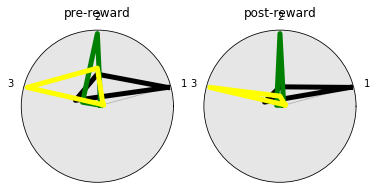

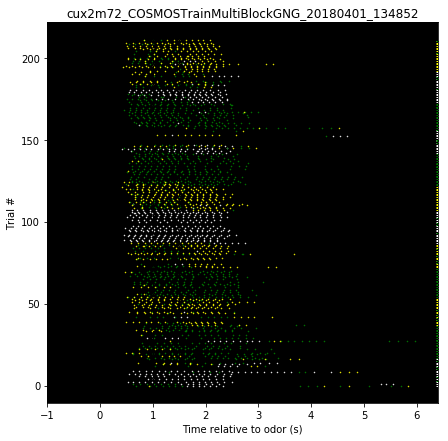

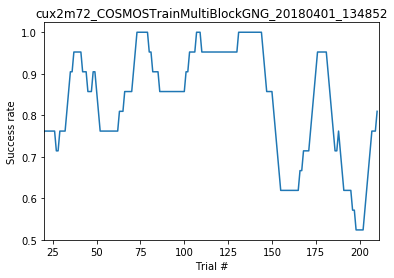

In [4]:
# Load data
CT = CosmosTraces(dataset)
BD = CT.bd

# Prepare train and test data

{'decoding_set': 1, 'train_feat': 'spikes', 'train_frac': 0.5, 'test_frac': 0.25, 'valid_frac': 0.25, 'remove_multi_licks': False, 'rand_seed': 0, 'bins_current': 1, 'bins_before': 0, 'bins_after': 0, 'standardize_X': True, 'center_Y': True}
Data split into train, test, validate sets. 
Fractions: Train 0.493, Test 0.245 Valid 0.253
Z-scoring X!!
Max X 69.555675567883
X_train: (30191, 1, 1240) X_test: (15012, 1, 1240)
# experiments: 5
Expt range: 3125 to 3129
Expt 3125, setting rand, nneurons 100
EVR: 0.7788103960563787
---> Saved to: /home/user/Dropbox/cosmos_data/decoding_results/7/expt_003125


/home/user/anaconda3/envs/cosmostools3/lib/python3.6/site-packages/keras/engine/sequential.py:109: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


45.26162004470825
Expt 3126, setting rand, nneurons 250
EVR: 0.35015464470485697
---> Saved to: /home/user/Dropbox/cosmos_data/decoding_results/7/expt_003126
45.537052154541016
Expt 3127, setting rand, nneurons 500
EVR: 0.20069502737340006
---> Saved to: /home/user/Dropbox/cosmos_data/decoding_results/7/expt_003127
47.17178678512573
Expt 3128, setting rand, nneurons 750
EVR: 0.14781743442234188
---> Saved to: /home/user/Dropbox/cosmos_data/decoding_results/7/expt_003128
48.78546905517578
Expt 3129, setting rand, nneurons 1000
EVR: 0.12633098048801555
---> Saved to: /home/user/Dropbox/cosmos_data/decoding_results/7/expt_003129


KeyboardInterrupt: 

> /home/user/anaconda3/envs/cosmostools3/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py(200)draw_text()
    198             # We pass '0' for angle here, since it will be rotated (in raster
    199             # space) in the following call to draw_text_image).
--> 200             font.set_text(s, 0, flags=flags)
    201         font.draw_glyphs_to_bitmap(antialiased=rcParams['text.antialiased'])
    202         d = font.get_descent() / 64.0

ipdb> quit()


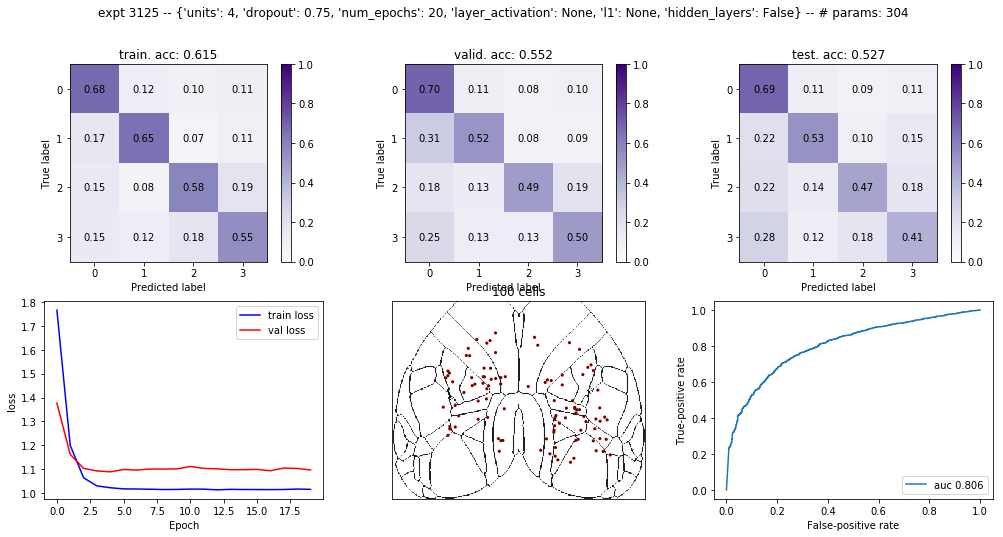

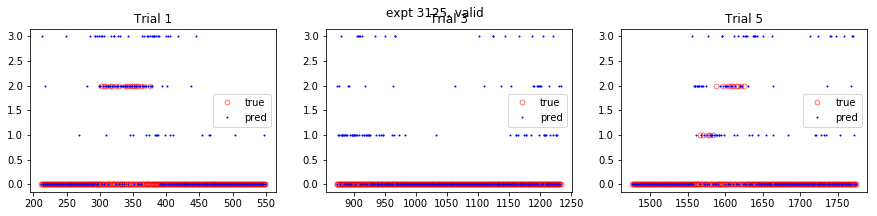

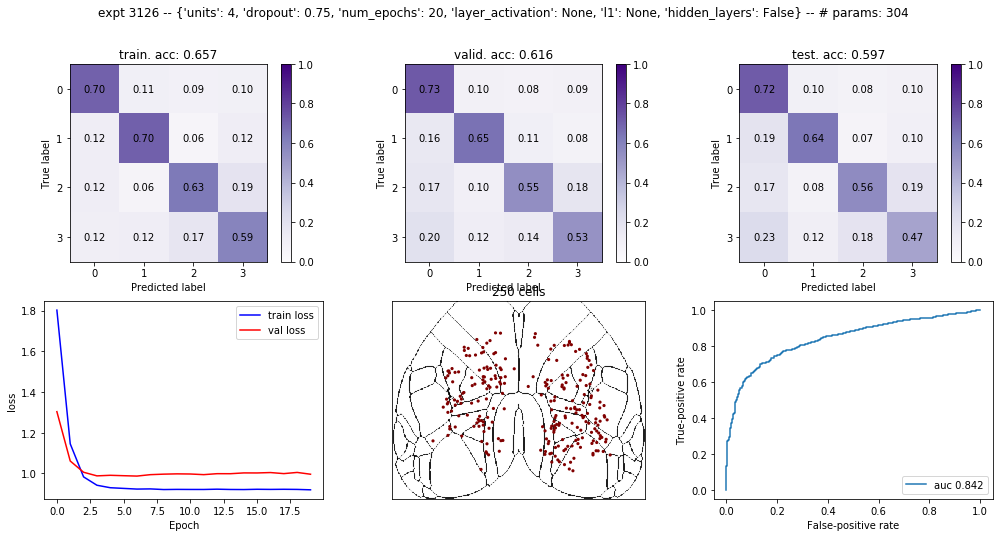

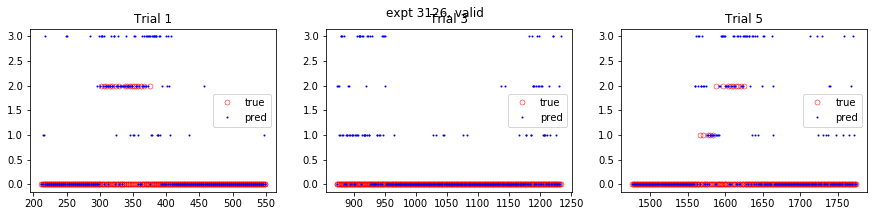

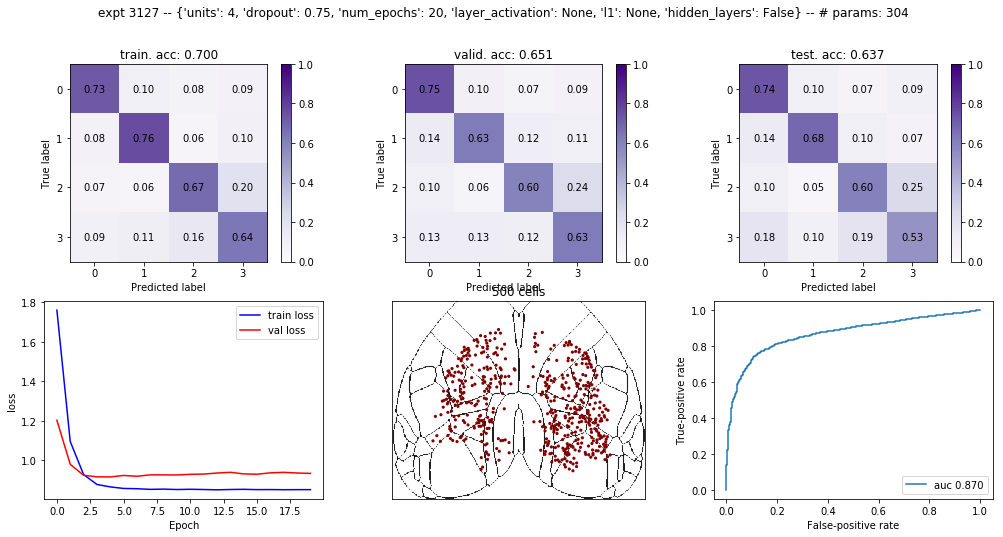

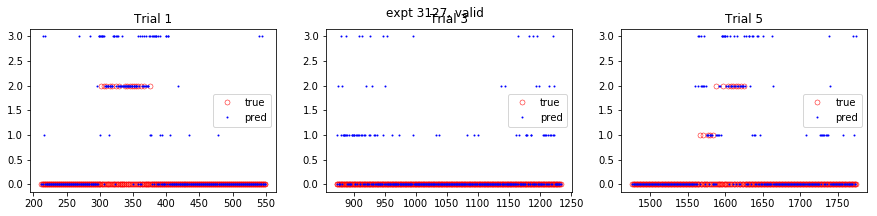

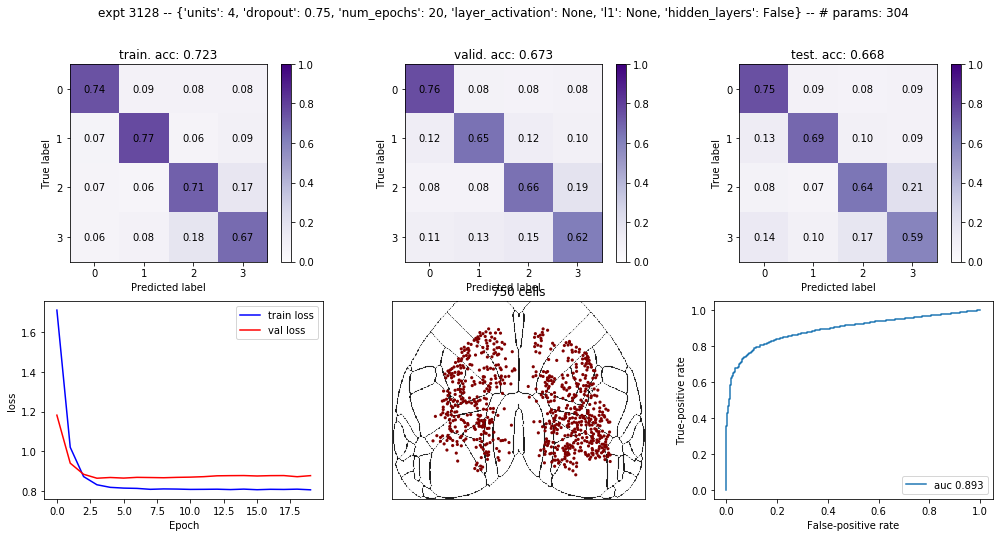

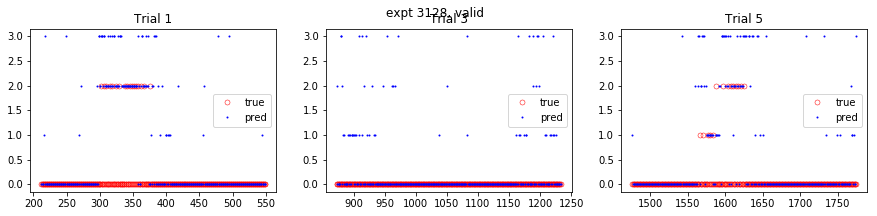

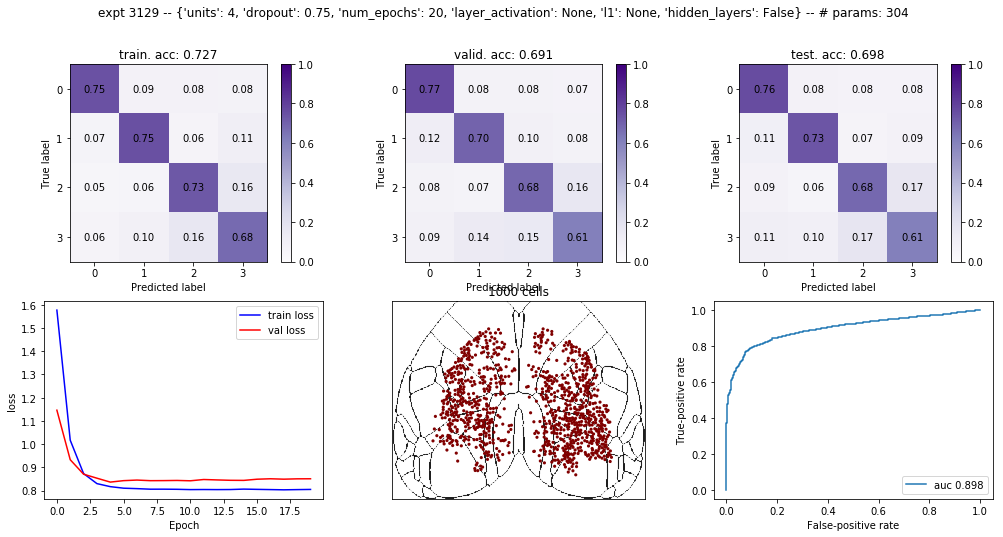

In [5]:
from cosmos.traces.lick_decoder import LickDecoder

### See du.select_experiment_group for information on the different expt_group_id's.
### Key groups: 8, 9, 4, 10

all_expts_str = []
T0 = time.time()

for expt_group_id in [8, 9, 4, 10]: #[8, 9, 4]: #[8, 9, 4, 10]:
    LD = LickDecoder(dataset_id, CT, decoding_save_dir, just_decode_licks=False)

    expts_info, expts_str = LD.decode_licks(nfolds=4, #1, #4 
                                            expt_group_id=expt_group_id, ### Make '0' for do_single_experiment
                                            do_pca = True,
                                            n_pca_components = 75, #75 ## CHANGE THIS BACK IF > 75 neurons
                                            do_shuffle_data = False)
    all_expts_str.append(expts_str)
print('Overall time in seconds:')
print(time.time() - T0)

In [ ]:
all_expts_str

In [ ]:
#### NOW RUN ON SHUFFLED DATA for each experiment
from cosmos.traces.lick_decoder import LickDecoder

### See du.select_experiment_group for information on the different expt_group_id's.
### Key groups: 8, 9, 4, 10

all_expts_str = []
T0 = time.time()

for expt_group_id in [8, 9, 4, 10]: #[8, 9, 4]: #[8, 9, 4, 10]:
    LD = LickDecoder(dataset_id, CT, decoding_save_dir, just_decode_licks=False)

    expts_info, expts_str = LD.decode_licks(nfolds=4, #1, #4 
                                            expt_group_id=expt_group_id, ### Make '0' for do_single_experiment
                                            do_pca = True,
                                            n_pca_components = 75, #75 ## CHANGE THIS BACK IF > 75 neurons
                                            do_shuffle_data = True)
    all_expts_str.append(expts_str)
print('Overall time in seconds:')
print(time.time() - T0)

In [ ]:
all_expts_str

In [ ]:
#### NOW RUN ON SHUFFLED DATA (just with all sources)
from cosmos.traces.lick_decoder import LickDecoder

### See du.select_experiment_group for information on the different expt_group_id's.
### Key groups: 8, 9, 4, 10

all_expts_str = []
T0 = time.time()

for expt_group_id in [10]: #[8, 9, 4, 10]: #[8, 9, 4]: #[8, 9, 4, 10]:
    LD = LickDecoder(dataset_id, CT, decoding_save_dir, just_decode_licks=False)

    expts_info, expts_str = LD.decode_licks(nfolds=4, #1, #4 
                                            expt_group_id=expt_group_id, ### Make '0' for do_single_experiment
                                            do_pca = True,
                                            n_pca_components = 75, #75
                                            do_shuffle_data = True)
    all_expts_str.append(expts_str)
print('Overall time in seconds:')
print(time.time() - T0)

In [ ]:
all_expts_str

### Copy the all_expts_str result below for eventual transfer to fig_classification_summary.

In [ ]:
### Record of previously run decoding expts.
concluded_expts = {
    
    
### Now with 50 pcs
["'id': 7, 'expt_nums': np.arange(3075, 3099),'expt_type': 'nneurons', 'info':8"]
["'id': 11, 'expt_nums': np.arange(1518, 1542),'expt_type': 'nneurons', 'info':8"]
["'id': 18, 'expt_nums': np.arange(1273, 1297),'expt_type': 'nneurons', 'info':8"]
    ["'id': 19, 'expt_nums': np.arange(1529, 1553),'expt_type': 'nneurons', 'info':8"]
    
### Now with 50 pcs, shuffled. 
["'id': 7, 'expt_nums': np.arange(3099, 3123),'expt_type': 'nneurons', 'info':8"]
["'id': 11, 'expt_nums': np.arange(1542, 1566),'expt_type': 'nneurons', 'info':8"]
["'id': 18, 'expt_nums': np.arange(1297, 1321),'expt_type': 'nneurons', 'info':8"]
["'id': 19, 'expt_nums': np.arange(1553, 1577),'expt_type': 'nneurons', 'info':8"]
    
### The below are not shuffled, 4way decoding. Nonlinear model. 1 bins centered. 75 neurons. 
###    X-standardized! NON-BINARIZED. 20200108
["'id': 7, 'expt_nums': np.arange(2935, 2955),'expt_type': 'nneurons', 'info':8",
 "'id': 7, 'expt_nums': np.arange(2955, 2979),'expt_type': 'neuron_set', 'info':9",
 "'id': 7, 'expt_nums': np.arange(2979, 2999),'expt_type': 'neuron_set', 'info':4",
 "'id': 7, 'expt_nums': np.arange(2999, 3003),'expt_type': 'neuron_set', 'info':10"]
["'id': 11, 'expt_nums': np.arange(1378, 1398),'expt_type': 'nneurons', 'info':8",
 "'id': 11, 'expt_nums': np.arange(1398, 1422),'expt_type': 'neuron_set', 'info':9",
 "'id': 11, 'expt_nums': np.arange(1422, 1442),'expt_type': 'neuron_set', 'info':4",
 "'id': 11, 'expt_nums': np.arange(1442, 1446),'expt_type': 'neuron_set', 'info':10"]
["'id': 18, 'expt_nums': np.arange(1133, 1153),'expt_type': 'nneurons', 'info':8",
 "'id': 18, 'expt_nums': np.arange(1153, 1177),'expt_type': 'neuron_set', 'info':9",
 "'id': 18, 'expt_nums': np.arange(1177, 1197),'expt_type': 'neuron_set', 'info':4",
 "'id': 18, 'expt_nums': np.arange(1197, 1201),'expt_type': 'neuron_set', 'info':10"]
["'id': 19, 'expt_nums': np.arange(1389, 1409),'expt_type': 'nneurons', 'info':8",
 "'id': 19, 'expt_nums': np.arange(1409, 1433),'expt_type': 'neuron_set', 'info':9",
 "'id': 19, 'expt_nums': np.arange(1433, 1453),'expt_type': 'neuron_set', 'info':4",
 "'id': 19, 'expt_nums': np.arange(1453, 1457),'expt_type': 'neuron_set', 'info':10"]
["'id': 35, 'expt_nums': np.arange(291, 311),'expt_type': 'nneurons', 'info':8",
 "'id': 35, 'expt_nums': np.arange(311, 335),'expt_type': 'neuron_set', 'info':9",
 "'id': 35, 'expt_nums': np.arange(335, 355),'expt_type': 'neuron_set', 'info':4",
 "'id': 35, 'expt_nums': np.arange(355, 359),'expt_type': 'neuron_set', 'info':10"]
    
### The below are circularly shuffled, 4way decoding. Nonlinear model. 1 bins centered. 75 neurons. 
###    X-standardized! NON-BINARIZED. 20200108
["'id': 7, 'expt_nums': np.arange(3003, 3023),'expt_type': 'nneurons', 'info':8",
 "'id': 7, 'expt_nums': np.arange(3023, 3047),'expt_type': 'neuron_set', 'info':9",
 "'id': 7, 'expt_nums': np.arange(3047, 3067),'expt_type': 'neuron_set', 'info':4",
 "'id': 7, 'expt_nums': np.arange(3067, 3071),'expt_type': 'neuron_set', 'info':10"]
["'id': 11, 'expt_nums': np.arange(1446, 1466),'expt_type': 'nneurons', 'info':8",
 "'id': 11, 'expt_nums': np.arange(1466, 1490),'expt_type': 'neuron_set', 'info':9",
 "'id': 11, 'expt_nums': np.arange(1490, 1510),'expt_type': 'neuron_set', 'info':4",
 "'id': 11, 'expt_nums': np.arange(1510, 1514),'expt_type': 'neuron_set', 'info':10"]
["'id': 18, 'expt_nums': np.arange(1201, 1221),'expt_type': 'nneurons', 'info':8",
 "'id': 18, 'expt_nums': np.arange(1221, 1245),'expt_type': 'neuron_set', 'info':9",
 "'id': 18, 'expt_nums': np.arange(1245, 1265),'expt_type': 'neuron_set', 'info':4",
 "'id': 18, 'expt_nums': np.arange(1265, 1269),'expt_type': 'neuron_set', 'info':10"]
["'id': 19, 'expt_nums': np.arange(1457, 1477),'expt_type': 'nneurons', 'info':8",
 "'id': 19, 'expt_nums': np.arange(1477, 1501),'expt_type': 'neuron_set', 'info':9",
 "'id': 19, 'expt_nums': np.arange(1501, 1521),'expt_type': 'neuron_set', 'info':4",
 "'id': 19, 'expt_nums': np.arange(1521, 1525),'expt_type': 'neuron_set', 'info':10"]
["'id': 35, 'expt_nums': np.arange(359, 379),'expt_type': 'nneurons', 'info':8",
 "'id': 35, 'expt_nums': np.arange(379, 403),'expt_type': 'neuron_set', 'info':9",
 "'id': 35, 'expt_nums': np.arange(403, 423),'expt_type': 'neuron_set', 'info':4",
 "'id': 35, 'expt_nums': np.arange(423, 427),'expt_type': 'neuron_set', 'info':10"]
    
    
### The below are circularly shuffled, 4way decoding. Nonlinear model. 1 bins centered. 75 neurons. 
###    X-standardized! NON-BINARIZED. 20200108
["'id': 7, 'expt_nums': np.arange(3071, 3075),'expt_type': 'neuron_set', 'info':10"]
["'id': 11, 'expt_nums': np.arange(1514, 1518),'expt_type': 'neuron_set', 'info':10"]
["'id': 18, 'expt_nums': np.arange(1269, 1273),'expt_type': 'neuron_set', 'info':10"]
["'id': 19, 'expt_nums': np.arange(1525, 1529),'expt_type': 'neuron_set', 'info':10"]

    
    
    
### The below are not shuffled, 4way decoding. 1 bins centered. 75 neurons. X-standardized! NON-BINARIZED. 20191211
["'id': 18, 'expt_nums': np.arange(989, 1009),'expt_type': 'nneurons', 'info':8",
 "'id': 18, 'expt_nums': np.arange(1009, 1033),'expt_type': 'neuron_set', 'info':9",
 "'id': 18, 'expt_nums': np.arange(1033, 1053),'expt_type': 'neuron_set', 'info':4",
 "'id': 18, 'expt_nums': np.arange(1053, 1057),'expt_type': 'neuron_set', 'info':10"]
["'id': 7, 'expt_nums': np.arange(2788, 2808),'expt_type': 'nneurons', 'info':8",
 "'id': 7, 'expt_nums': np.arange(2808, 2832),'expt_type': 'neuron_set', 'info':9",
 "'id': 7, 'expt_nums': np.arange(2832, 2852),'expt_type': 'neuron_set', 'info':4",
 "'id': 7, 'expt_nums': np.arange(2852, 2856),'expt_type': 'neuron_set', 'info':10"]
    ["'id': 11, 'expt_nums': np.arange(1234, 1254),'expt_type': 'nneurons', 'info':8",
 "'id': 11, 'expt_nums': np.arange(1254, 1278),'expt_type': 'neuron_set', 'info':9",
 "'id': 11, 'expt_nums': np.arange(1278, 1298),'expt_type': 'neuron_set', 'info':4",
 "'id': 11, 'expt_nums': np.arange(1298, 1302),'expt_type': 'neuron_set', 'info':10"]
["'id': 19, 'expt_nums': np.arange(1245, 1265),'expt_type': 'nneurons', 'info':8",
 "'id': 19, 'expt_nums': np.arange(1265, 1289),'expt_type': 'neuron_set', 'info':9",
 "'id': 19, 'expt_nums': np.arange(1289, 1309),'expt_type': 'neuron_set', 'info':4",
 "'id': 19, 'expt_nums': np.arange(1309, 1313),'expt_type': 'neuron_set', 'info':10"]
    ["'id': 35, 'expt_nums': np.arange(145, 165),'expt_type': 'nneurons', 'info':8",
 "'id': 35, 'expt_nums': np.arange(165, 189),'expt_type': 'neuron_set', 'info':9",
 "'id': 35, 'expt_nums': np.arange(189, 209),'expt_type': 'neuron_set', 'info':4",
 "'id': 35, 'expt_nums': np.arange(209, 213),'expt_type': 'neuron_set', 'info':10"]
    
### The below are shuffled, 4way decoding. 1 bins centered. 75 neurons. X-standardized! NON-BINARIZED. 20191211
["'id': 18, 'expt_nums': np.arange(1057, 1061),'expt_type': 'neuron_set', 'info':10"]
["'id': 7, 'expt_nums': np.arange(2856, 2860),'expt_type': 'neuron_set', 'info':10"]
["'id': 11, 'expt_nums': np.arange(1302, 1306),'expt_type': 'neuron_set', 'info':10"]
["'id': 19, 'expt_nums': np.arange(1313, 1317),'expt_type': 'neuron_set', 'info':10"]
["'id': 35, 'expt_nums': np.arange(213, 217),'expt_type': 'neuron_set', 'info':10"]
    
### The below are circular shuffled, 4way decoding. 1 bins centered. 75 neurons. X-standardized! NON-BINARIZED. 20191211
["'id': 18, 'expt_nums': np.arange(1061, 1065),'expt_type': 'neuron_set', 'info':10"]
["'id': 7, 'expt_nums': np.arange(2860, 2864),'expt_type': 'neuron_set', 'info':10"]
["'id': 19, 'expt_nums': np.arange(1317, 1321),'expt_type': 'neuron_set', 'info':10"]
["'id': 11, 'expt_nums': np.arange(1306, 1310),'expt_type': 'neuron_set', 'info':10"]
["'id': 35, 'expt_nums': np.arange(219, 223),'expt_type': 'neuron_set', 'info':10"]
    
    
### The below are CIRCULAR shuffled, 4way decoding. 1 bins centered. 75 neurons. X-standardized! NON-BINARIZED. 20191211
["'id': 18, 'expt_nums': np.arange(1065, 1085),'expt_type': 'nneurons', 'info':8",
 "'id': 18, 'expt_nums': np.arange(1085, 1109),'expt_type': 'neuron_set', 'info':9",
 "'id': 18, 'expt_nums': np.arange(1109, 1129),'expt_type': 'neuron_set', 'info':4",
 "'id': 18, 'expt_nums': np.arange(1129, 1133),'expt_type': 'neuron_set', 'info':10"]
    ["'id': 7, 'expt_nums': np.arange(2864, 2884),'expt_type': 'nneurons', 'info':8",
 "'id': 7, 'expt_nums': np.arange(2884, 2908),'expt_type': 'neuron_set', 'info':9",
 "'id': 7, 'expt_nums': np.arange(2908, 2928),'expt_type': 'neuron_set', 'info':4",
 "'id': 7, 'expt_nums': np.arange(2928, 2932),'expt_type': 'neuron_set', 'info':10"]
["'id': 11, 'expt_nums': np.arange(1310, 1330),'expt_type': 'nneurons', 'info':8",
 "'id': 11, 'expt_nums': np.arange(1330, 1354),'expt_type': 'neuron_set', 'info':9",
 "'id': 11, 'expt_nums': np.arange(1354, 1374),'expt_type': 'neuron_set', 'info':4",
 "'id': 11, 'expt_nums': np.arange(1374, 1378),'expt_type': 'neuron_set', 'info':10"]
["'id': 19, 'expt_nums': np.arange(1321, 1341),'expt_type': 'nneurons', 'info':8",
 "'id': 19, 'expt_nums': np.arange(1341, 1365),'expt_type': 'neuron_set', 'info':9",
 "'id': 19, 'expt_nums': np.arange(1365, 1385),'expt_type': 'neuron_set', 'info':4",
 "'id': 19, 'expt_nums': np.arange(1385, 1389),'expt_type': 'neuron_set', 'info':10"]
["'id': 35, 'expt_nums': np.arange(223, 243),'expt_type': 'nneurons', 'info':8",
 "'id': 35, 'expt_nums': np.arange(243, 267),'expt_type': 'neuron_set', 'info':9",
 "'id': 35, 'expt_nums': np.arange(267, 287),'expt_type': 'neuron_set', 'info':4",
 "'id': 35, 'expt_nums': np.arange(287, 291),'expt_type': 'neuron_set', 'info':10"]
    
    
    
    
    
### The below are not shuffled, 4way decoding. 3 bins centered. 75 neurons. X-standardized! NON-BINARIZED. 20190814
["'id': 18, 'expt_nums': np.arange(917, 937),'expt_type': 'nneurons', 'info':8",
 "'id': 18, 'expt_nums': np.arange(937, 961),'expt_type': 'neuron_set', 'info':9",
 "'id': 18, 'expt_nums': np.arange(961, 981),'expt_type': 'neuron_set', 'info':4",
 "'id': 18, 'expt_nums': np.arange(981, 985),'expt_type': 'neuron_set', 'info':10"]
["'id': 7, 'expt_nums': np.arange(2716, 2736),'expt_type': 'nneurons', 'info':8",
 "'id': 7, 'expt_nums': np.arange(2736, 2760),'expt_type': 'neuron_set', 'info':9",
 "'id': 7, 'expt_nums': np.arange(2760, 2780),'expt_type': 'neuron_set', 'info':4",
 "'id': 7, 'expt_nums': np.arange(2780, 2784),'expt_type': 'neuron_set', 'info':10"]
["'id': 11, 'expt_nums': np.arange(1162, 1182),'expt_type': 'nneurons', 'info':8",
 "'id': 11, 'expt_nums': np.arange(1182, 1206),'expt_type': 'neuron_set', 'info':9",
 "'id': 11, 'expt_nums': np.arange(1206, 1226),'expt_type': 'neuron_set', 'info':4",
 "'id': 11, 'expt_nums': np.arange(1226, 1230),'expt_type': 'neuron_set', 'info':10"]
["'id': 19, 'expt_nums': np.arange(1173, 1193),'expt_type': 'nneurons', 'info':8",
 "'id': 19, 'expt_nums': np.arange(1193, 1217),'expt_type': 'neuron_set', 'info':9",
 "'id': 19, 'expt_nums': np.arange(1217, 1237),'expt_type': 'neuron_set', 'info':4",
 "'id': 19, 'expt_nums': np.arange(1237, 1241),'expt_type': 'neuron_set', 'info':10"]
["'id': 35, 'expt_nums': np.arange(73, 93),'expt_type': 'nneurons', 'info':8",
 "'id': 35, 'expt_nums': np.arange(93, 117),'expt_type': 'neuron_set', 'info':9",
 "'id': 35, 'expt_nums': np.arange(117, 137),'expt_type': 'neuron_set', 'info':4",
 "'id': 35, 'expt_nums': np.arange(137, 141),'expt_type': 'neuron_set', 'info':10"]
    
### The below are shuffled, 4way decoding. 3 bins centered. 75 neurons. X-standardized! NON-BINARIZED. 20190814
["'id': 18, 'expt_nums': np.arange(985, 989),'expt_type': 'neuron_set', 'info':10"]
["'id': 7, 'expt_nums': np.arange(2784, 2788),'expt_type': 'neuron_set', 'info':10"]
["'id': 11, 'expt_nums': np.arange(1230, 1234),'expt_type': 'neuron_set', 'info':10"]
["'id': 19, 'expt_nums': np.arange(1241, 1245),'expt_type': 'neuron_set', 'info':10"]
["'id': 35, 'expt_nums': np.arange(141, 145),'expt_type': 'neuron_set', 'info':10"]
    
    
### The below are not shuffled, 4way decoding. 3 bins centered on timepoint. 75 neurons. NON-BINARIZED. 20190814
["'id': 7, 'expt_nums': np.arange(2644, 2664),'expt_type': 'nneurons', 'info':8",
 "'id': 7, 'expt_nums': np.arange(2664, 2688),'expt_type': 'neuron_set', 'info':9",
 "'id': 7, 'expt_nums': np.arange(2688, 2708),'expt_type': 'neuron_set', 'info':4",
 "'id': 7, 'expt_nums': np.arange(2708, 2712),'expt_type': 'neuron_set', 'info':10"]
    ["'id': 11, 'expt_nums': np.arange(1090, 1110),'expt_type': 'nneurons', 'info':8",
 "'id': 11, 'expt_nums': np.arange(1110, 1134),'expt_type': 'neuron_set', 'info':9",
 "'id': 11, 'expt_nums': np.arange(1134, 1154),'expt_type': 'neuron_set', 'info':4",
 "'id': 11, 'expt_nums': np.arange(1154, 1158),'expt_type': 'neuron_set', 'info':10"]
    ["'id': 18, 'expt_nums': np.arange(842, 862),'expt_type': 'nneurons', 'info':8",
 "'id': 18, 'expt_nums': np.arange(862, 886),'expt_type': 'neuron_set', 'info':9",
 "'id': 18, 'expt_nums': np.arange(886, 906),'expt_type': 'neuron_set', 'info':4",
 "'id': 18, 'expt_nums': np.arange(906, 910),'expt_type': 'neuron_set', 'info':10"]
["'id': 19, 'expt_nums': np.arange(1101, 1121),'expt_type': 'nneurons', 'info':8",
 "'id': 19, 'expt_nums': np.arange(1121, 1145),'expt_type': 'neuron_set', 'info':9",
 "'id': 19, 'expt_nums': np.arange(1145, 1165),'expt_type': 'neuron_set', 'info':4",
 "'id': 19, 'expt_nums': np.arange(1165, 1169),'expt_type': 'neuron_set', 'info':10"]
    
    
### The below are shuffled, 4way decoding. 3 bins centered on timepoint. 75 neurons. NON-BINARIZED. 20190814
["'id': 7, 'expt_nums': np.arange(2712, 2716),'expt_type': 'neuron_set', 'info':10"]
    ["'id': 11, 'expt_nums': np.arange(1158, 1162),'expt_type': 'neuron_set', 'info':10"]
["'id': 18, 'expt_nums': np.arange(910, 914),'expt_type': 'neuron_set', 'info':10"]
["'id': 19, 'expt_nums': np.arange(1169, 1173),'expt_type': 'neuron_set', 'info':10"]

    
    
    
    
    
    ### The below are not shuffled. 4way decoding. 3 bins centered on timepoint. 75 neurons.
["'id': 7, 'expt_nums': np.arange(2572, 2592),'expt_type': 'nneurons', 'info':8",
 "'id': 7, 'expt_nums': np.arange(2592, 2616),'expt_type': 'neuron_set', 'info':9",
 "'id': 7, 'expt_nums': np.arange(2616, 2636),'expt_type': 'neuron_set', 'info':4",
 "'id': 7, 'expt_nums': np.arange(2636, 2640),'expt_type': 'neuron_set', 'info':10"]
["'id': 18, 'expt_nums': np.arange(770, 790),'expt_type': 'nneurons', 'info':8",
 "'id': 18, 'expt_nums': np.arange(790, 814),'expt_type': 'neuron_set', 'info':9",
 "'id': 18, 'expt_nums': np.arange(814, 834),'expt_type': 'neuron_set', 'info':4",
 "'id': 18, 'expt_nums': np.arange(834, 838),'expt_type': 'neuron_set', 'info':10"]
["'id': 19, 'expt_nums': np.arange(1029, 1049),'expt_type': 'nneurons', 'info':8",
 "'id': 19, 'expt_nums': np.arange(1049, 1073),'expt_type': 'neuron_set', 'info':9",
 "'id': 19, 'expt_nums': np.arange(1073, 1093),'expt_type': 'neuron_set', 'info':4",
 "'id': 19, 'expt_nums': np.arange(1093, 1097),'expt_type': 'neuron_set', 'info':10"]
["'id': 11, 'expt_nums': np.arange(1018, 1038),'expt_type': 'nneurons', 'info':8",
 "'id': 11, 'expt_nums': np.arange(1038, 1062),'expt_type': 'neuron_set', 'info':9",
 "'id': 11, 'expt_nums': np.arange(1062, 1082),'expt_type': 'neuron_set', 'info':4",
 "'id': 11, 'expt_nums': np.arange(1082, 1086),'expt_type': 'neuron_set', 'info':10"]
    
    ### The below are shuffled. 4way decoding. 3 bins centered on timepoint. 75 neurons.
["'id': 7, 'expt_nums': np.arange(2640, 2644),'expt_type': 'neuron_set', 'info':10"]
["'id': 18, 'expt_nums': np.arange(838, 842),'expt_type': 'neuron_set', 'info':10"]
["'id': 19, 'expt_nums': np.arange(1097, 1101),'expt_type': 'neuron_set', 'info':10"]
["'id': 11, 'expt_nums': np.arange(1086, 1090),'expt_type': 'neuron_set', 'info':10"]
}



# concluded_expts = {
#     ### The below are not shuffled. 4way decoding. 2 bins before and during timepoint.
# ["'id': 7, 'expt_nums': np.arange(2500, 2520),'expt_type': 'nneurons', 'info':8",
#  "'id': 7, 'expt_nums': np.arange(2520, 2544),'expt_type': 'neuron_set', 'info':9",
#  "'id': 7, 'expt_nums': np.arange(2544, 2564),'expt_type': 'neuron_set', 'info':4",
#  "'id': 7, 'expt_nums': np.arange(2564, 2568),'expt_type': 'neuron_set', 'info':10"]
    
# ["'id': 18, 'expt_nums': np.arange(698, 718),'expt_type': 'nneurons', 'info':8",
#  "'id': 18, 'expt_nums': np.arange(718, 742),'expt_type': 'neuron_set', 'info':9",
#  "'id': 18, 'expt_nums': np.arange(742, 762),'expt_type': 'neuron_set', 'info':4",
#  "'id': 18, 'expt_nums': np.arange(762, 766),'expt_type': 'neuron_set', 'info':10"]
    
# ["'id': 19, 'expt_nums': np.arange(957, 977),'expt_type': 'nneurons', 'info':8",
#  "'id': 19, 'expt_nums': np.arange(977, 1001),'expt_type': 'neuron_set', 'info':9",
#  "'id': 19, 'expt_nums': np.arange(1001, 1021),'expt_type': 'neuron_set', 'info':4",
#  "'id': 19, 'expt_nums': np.arange(1021, 1025),'expt_type': 'neuron_set', 'info':10"]
    
# ["'id': 11, 'expt_nums': np.arange(946, 966),'expt_type': 'nneurons', 'info':8",
#  "'id': 11, 'expt_nums': np.arange(966, 990),'expt_type': 'neuron_set', 'info':9",
#  "'id': 11, 'expt_nums': np.arange(990, 1010),'expt_type': 'neuron_set', 'info':4",
#  "'id': 11, 'expt_nums': np.arange(1010, 1014),'expt_type': 'neuron_set', 'info':10"]
    
#     ### The below are shuffled. 4way decoding. 2 bins before and during timepoint.
#     ["'id': 7, 'expt_nums': np.arange(2568, 2572),'expt_type': 'neuron_set', 'info':10"]
#     ["'id': 18, 'expt_nums': np.arange(766, 770),'expt_type': 'neuron_set', 'info':10"]
#     ["'id': 19, 'expt_nums': np.arange(1025, 1029),'expt_type': 'neuron_set', 'info':10"]
#     ["'id': 11, 'expt_nums': np.arange(1014, 1018),'expt_type': 'neuron_set', 'info':10"]
    
# }


### Now copy information about decoding runs to fig_classification_summary notebook.